# Lab 2: Regularized Least Square
In this lab, we focus on RLS to address linear regression problems. 

In this lab, we have to:
- **(Task 1)** implement RLS to solve linear regression problems
- **(Task 2)** observe performance of RLS changing the noise in the data and the regularization parameter
- **(Task 3)** implement K-Fold Cross-Validation algorithm for RLS


In [196]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Data generation
To generate linear regression data, we use the `linearRegrFunction` introduced in Lab0.

In [197]:
from numpy.random import Generator


def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)


def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise, rng: int | Generator | None = None):
    rng = _check_random_generator(rng)

    X = np.zeros((n,D), dtype=np.float64)
    for i in range(D):
        X[:,i] = rng.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = rng.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise
    
    return X, Y 

### Example: Noiseless dataset


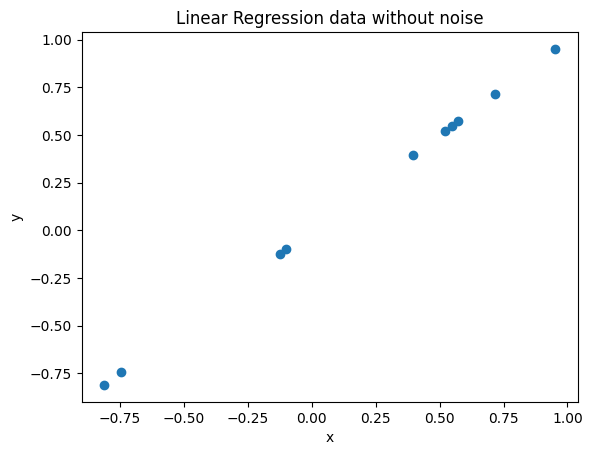

In [198]:
n = 10
D = 1
low_D, high_D = [-1], [1]
w = np.array(1.0).reshape(1, 1)
noise_std = 0.0
random_seed = 42

# Data generation
X, Y = linearRegrFunction(n, D, low_D, high_D, w, noise_std, rng=random_seed)

# Plot of the data
_, ax = plt.subplots()
ax.set_title("Linear Regression data without noise")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X, Y)

## Task 1: RLS regressor
We want to implement the `regularizedLSTrain` function which train RLS regression.

The signature of `regularizedLSTrain` is the following:

`w = regularizedLSTrain(Xtr, Ytr, lam)`

where:
- **Xtr** are the training inputs
- **Ytr** are the training outputs
- **lam** is the regularization parameter $\lambda$

To implement this function, you will need to use the following functions from numpy:

- [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
- [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)

Consider 

**$(X_{tr}^\intercal X_{tr} + \lambda n I)w = X_{tr}^\intercal Y_{tr}$**

Let $A = X_{tr}^\intercal X_{tr} + \lambda n I$ and $b = X_{tr}^\intercal Y_{tr}$, we can find $w$ with the following steps:
1. First build the left-hand side matrix `A`, and the right-hand side matrix `b`.
2. Compute the Cholesky decomposition of `A` (note that the numpy function will provide a lower-triangular matrix)
3. You will have to solve two triangular systems, one using the Cholesky decomposition, and the other using its transpose.

In [ ]:
def regularizedLSTrain(Xtr, Ytr, lam):
    # Step 1:
    n , D = Xtr.shape
    A= Xtr.T @ Xtr + lam * n * np.eye(D)
    B= Xtr.T @ Ytr
    
    # Step 2:
    L = np.linalg.cholesky(A)

    # Step 3:
    y = scipy.linalg.solve_triangular(L, B, lower=True)     # Solve L*y = b
    w = scipy.linalg.solve_triangular(L.T, y, lower=False)  # Solve L.T*w = y
    
    return w

We need also to implement a function `regularizedLSTest` which given a test set `Xte` and the `w` obtained using `regularizedLSTrain`, it returns `Ypred` containing the predictions

In [200]:
def regularizedLSTest(w, Xte):
    return Xte @ w

To evaluate the performance of RLS regressor, we need a function to estimate the error.

Given two vectors `Ytrue` (real outputs) and `Ypred` (predicted outputs), we can measure the error obtained when predicting `Ypred` instead of `Ytrue` with the MSE (Mean Square Error)

In [201]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

Now we can build an easy example to observe how our model works:
- Generate a training set with **ntrain** points and a test set with **ntest** points 
- Train RLS with `regularizedLSTrain` function and test it with `regularizedLSTest` on test set
- Compute the training and test error 

In [202]:
n_train = 100
n_test = 50
D = 1
low_D = [-1] * D
high_D = [5] * D
rng = np.random.default_rng(random_seed)
w_true = rng.standard_normal((D, 1))
noise_std = 0.1

lam = 1e-3

# Generate a training set with n_train points and a test set with n_test
Xtr, Ytr = linearRegrFunction(n_train, D, low_D, high_D, w_true, noise_std, rng=random_seed)
Xte, Yte = linearRegrFunction(n_test, D, low_D, high_D, w_true, noise_std, rng=random_seed)

# Train RLS
w_pred = regularizedLSTrain(Xtr, Ytr, lam)

# Compute predictions on training and test set
Ytr_pred = regularizedLSTest(w_pred, Xtr)
Yte_pred = regularizedLSTest(w_pred, Xte)

train_err = calcError(Ytr_pred, Ytr)
test_err =  calcError(Yte_pred, Yte)

print(f'[--] Training error: {train_err:.7f}\t Test error: {test_err:.7f}')

[--] Training error: 0.0095949	 Test error: 0.0060281


## Task 2: Changing $\lambda$
Now we can play with our model changing the noise level in the data and changing the $\lambda$ parameter.

Let's start by changing $\lambda$ and fixing the other parameters.

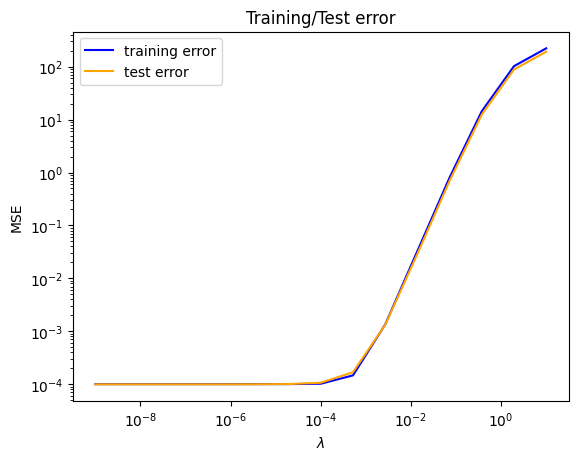

In [203]:
n_train = 500
n_test = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.arange(D)[:, None] + 10
noise_std = 0.01

# Data generation
Xtr, Ytr = linearRegrFunction(n_train, D, low_D, high_D, w_true, noise_std, rng=random_seed)
Xte, Yte = linearRegrFunction(n_test, D, low_D, high_D, w_true, noise_std, rng=random_seed)

lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []

for lam in lam_list:
    # Train RLS
    w_pred = regularizedLSTrain(Xtr, Ytr, lam)
    
    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w_pred, Xtr)
    Yte_pred = regularizedLSTest(w_pred, Xte)
    
    # Compute training and test error and store them on tr_err and te_err
    train_err = calcError(Ytr_pred, Ytr)
    test_err =  calcError(Yte_pred, Yte)
    tr_err.append(train_err)
    te_err.append(test_err)


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.loglog(lam_list, tr_err, '-', c="blue", label="training error")
ax.loglog(lam_list, te_err, '-', c="orange", label="test error")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best");

Explain here what happens when $\lambda$ increases: 

as $\lambda$ increases, the model becomes more regularized, which means it is less sensitive to the training data. increasing the MSE.

## Task 3: K-Fold Cross Validation for RLS
Now, we want to implement the K-Fold Cross Validation for RLS. 

In specific we want to implement the `KFoldCVRLS` function which, given a training set **Xtr** and **Ytr**, a number of folds **KF** and a set of values for $\lambda$ (**regpar_list**) and returns the $\lambda$ which minimize the average validation error **bestlam**, the mean validation error **val_mean**, the validation error variance **val_var**, the mean training error **tr_mean** and the training error variance **tr_var**.

`bestlam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)`

**Hint:** this function is very similar to K-Fold Cross-Validation algorithm for KNN (Lab1)

In [204]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list, rng: int | Generator | None = None):
    assert KF > 1, "A number of folds (KF) should be > 1"

    rng = _check_random_generator(rng)

    # Ensures that regpar_list is a numpy array
    regpar_list = np.asarray(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = n_tot // KF

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF), dtype=np.float64)
    val_errors = np.zeros((num_regpar, KF), dtype=np.float64)

    # 1) One permutation, once
    rand_idx = rng.permutation(n_tot)
    # 2) Split once into K disjoint folds
    split_idx = np.array_split(rand_idx, KF)
    # 3) Outer loop over folds; inner over hyperparams
    for fold in range(KF):
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True
        train_mask = ~val_mask

        for idx, regpar in enumerate(regpar_list):
            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[train_mask, :]
            Y = Ytr[train_mask, :]
            X_val =  Xtr[val_mask, :]
            Y_val = Ytr[val_mask, :]
            
            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)
            
            # Compute the training error of the RLS regression for the given value of `regpar`
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of `regpar`
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)

    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Use `KFoldCVRLS` to find the best regularization parameter 

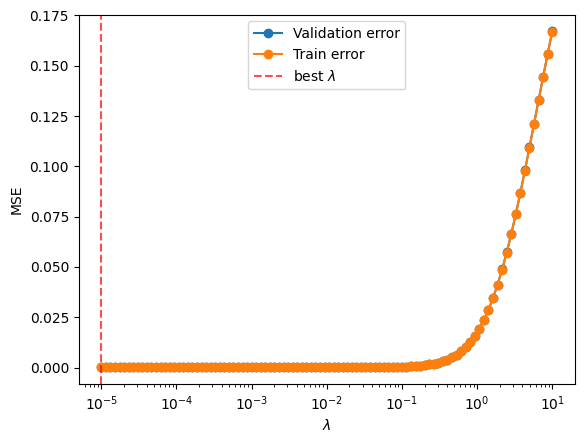

In [205]:
n = 1_000
D = 1
sigma_noise = 0.5
rng = np.random.default_rng(random_seed)
w_true = rng.standard_normal((D, 1))
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [-3] * D
high_D = [3] * D

# Generate training set
# Insert your code here
Xtr, Ytr = linearRegrFunction(n, D, low_D, high_D, w_true, noise_std, rng=random_seed)
Xte, Yte = linearRegrFunction(n, D, low_D, high_D, w_true, noise_std, rng=random_seed)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars, rng=random_seed)

# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best");

Plot the regression curve using the best $\lambda$ (found with `KFoldCVRLS`) and using the worst $\lambda$

[--] Best lambda found: 0.0000100
[--] Worst lambda found: 10.0000000


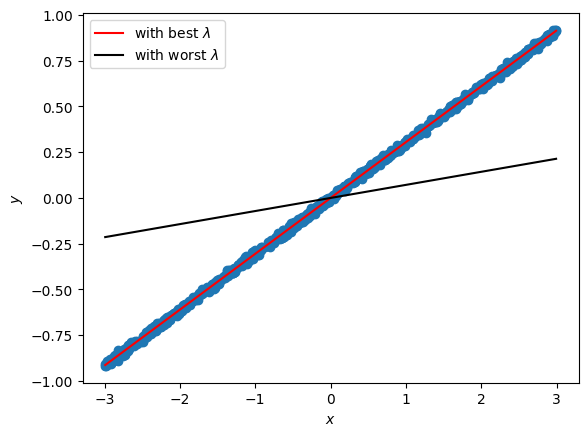

In [206]:
print(f'[--] Best lambda found: {bestlam:.7f}')
# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)

# Insert your code here
worstlam = reg_pars[np.argmax(Vm)]
print(f'[--] Worst lambda found: {worstlam:.7f}')
w_worst = regularizedLSTrain(Xtr, Ytr, worstlam)
Ypred_worst = regularizedLSTest(w_worst, Xte)

_, ax = plt.subplots()
ax.scatter(Xtr, Ytr)
idx_te = np.argsort(Xte.squeeze())
ax.plot(Xte[idx_te], Ypred_best[idx_te],  c="red", label="with best $\lambda$")
ax.plot(Xte[idx_te], Ypred_worst[idx_te],c="black", label="with worst $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc="best");

Use the best $\lambda$ found to train the model on the full training set and compute the test error on the following test set.   

In [207]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, w_true, sigma_noise, rng=random_seed)
print(f'[--] Best lambda found: {bestlam:.7f}')

# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)
print(f'[--] Test error: {test_err:.7f}')

[--] Best lambda found: 0.0000100
[--] Test error: 0.2575283


### Repeat the procedure on a different dataset

Create new training **and** test datasets, sampled in a non-symmetric range (for example you can set the `low_D` and `high_D` parameters of the `linearRegrFunction` function to 2 and 5).

Then repeat the K-fold CV procedure, and check whether the best regularization parameter changes!

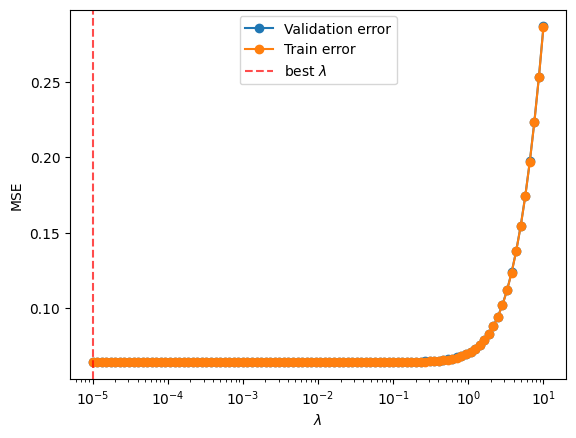

In [208]:
n = 1_000
D = 1
sigma_noise = 0.5
rng = np.random.default_rng(random_seed)
w_true = rng.standard_normal((D, 1))
reg_pars = np.logspace(-5, 1, 100)
noise_std = 0.25
KF = 5

low_D = [2] * D
high_D = [5] * D

# Generate training set
# Insert your code here
Xtr, Ytr = linearRegrFunction(n, D, low_D, high_D, w_true, noise_std, rng=random_seed)
Xte, Yte = linearRegrFunction(n, D, low_D, high_D, w_true, noise_std, rng=random_seed)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars, rng=random_seed)

# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best");

[--] Best lambda found: 0.0000100
[--] Worst lambda found: 10.0000000


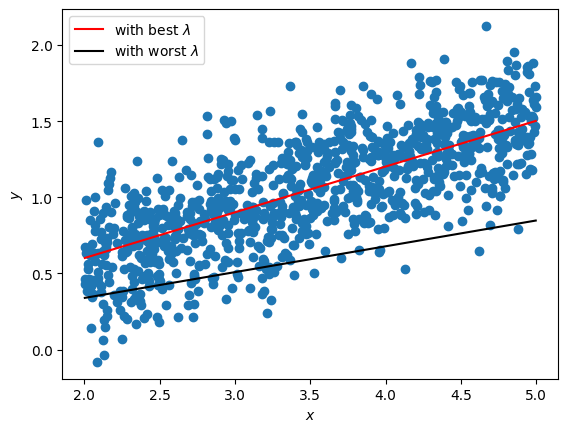

In [209]:
print(f'[--] Best lambda found: {bestlam:.7f}')
# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)

# Insert your code here
worstlam = reg_pars[np.argmax(Vm)]
print(f'[--] Worst lambda found: {worstlam:.7f}')
w_worst = regularizedLSTrain(Xtr, Ytr, worstlam)
Ypred_worst = regularizedLSTest(w_worst, Xte)

_, ax = plt.subplots()
ax.scatter(Xtr, Ytr)
idx_te = np.argsort(Xte.squeeze())
ax.plot(Xte[idx_te], Ypred_best[idx_te],  c="red", label="with best $\lambda$")
ax.plot(Xte[idx_te], Ypred_worst[idx_te],c="black", label="with worst $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc="best");

In [210]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, w_true, sigma_noise, rng=random_seed)
print(f'[--] Best lambda found: {bestlam:.7f}')

# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)
print(f'[--] Test error: {test_err:.7f}')

[--] Best lambda found: 0.0000100
[--] Test error: 0.2587764


after seting `low_D` and `high_D` to 2 and 5, and incrising the noise_std to 0.25 the Best lambda is still 0.0000100